In [1]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Import data from DB for modeling

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
results = client.census_DB.census.find()
cluster_data = []
for result in results:
    del result['_id']
    cluster_data.append(result)

In [4]:
cleaned_census_data = pd.DataFrame(cluster_data)
cleaned_census_data

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
9002,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


In [5]:
# Dropping the unwanted columns before performing the Machine Learning model
cleaned_census_data1 = cleaned_census_data.drop(['state','state_po', 'county_name'], axis=1)
cleaned_census_data1.head()

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,9140.0,43.1,44885.0,21883.0,14.070022,Republican


In [6]:
# making the target column as a binary indicator , so that I can utilize it in the Logistic Regression ML
winner_dict = {'Republican': 0, 'Democrat': 1}
cleaned_census_data1 = cleaned_census_data1.replace({'Winner': winner_dict})
cleaned_census_data1.head()

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,12668.0,43.0,39028.0,20968.0,13.245974,0
1,2012,40330.0,39.6,34148.0,17763.0,20.300025,0
2,2012,52964.0,29.7,47960.0,21375.0,15.246205,0
3,2012,35507.0,39.1,39101.0,19788.0,18.244290,0
4,2012,9140.0,43.1,44885.0,21883.0,14.070022,0


# Build Logistic Regression Model

In [7]:
# selecting the Target and features for performing ML
target = 'Winner'
features = ['year','Population','Median Age','Household Income','Per Capita Income','Poverty Rate']
print(features)

['year', 'Population', 'Median Age', 'Household Income', 'Per Capita Income', 'Poverty Rate']


In [8]:
# Dropping the rows of 2020 so that I can make a model with rest of the data
X = cleaned_census_data1.loc[cleaned_census_data1['year'] != 2020, features].values
X

array([[2.01200000e+03, 1.26680000e+04, 4.30000000e+01, 3.90280000e+04,
        2.09680000e+04, 1.32459741e+01],
       [2.01200000e+03, 4.03300000e+04, 3.96000000e+01, 3.41480000e+04,
        1.77630000e+04, 2.03000248e+01],
       [2.01200000e+03, 5.29640000e+04, 2.97000000e+01, 4.79600000e+04,
        2.13750000e+04, 1.52462050e+01],
       ...,
       [2.01600000e+03, 2.58890000e+04, 4.65000000e+01, 4.33730000e+04,
        2.51360000e+04, 1.43690370e+01],
       [2.01600000e+03, 3.20210000e+04, 4.83000000e+01, 4.30820000e+04,
        2.44550000e+04, 1.37378595e+01],
       [2.01600000e+03, 2.84559000e+05, 3.16000000e+01, 4.68420000e+04,
        2.60830000e+04, 2.07847933e+01]])

In [9]:
# Dropping the rows of 2020 so that I can make a model with rest of the data
y = cleaned_census_data1.loc[cleaned_census_data1['year'] != 2020, target].values
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [10]:
# Split our data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
# create a logistic regression model

classifier = LogisticRegression()
classifier

LogisticRegression()

In [12]:
# Fit(train) our model by using the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Indicating how far my training and test data are accurately performing
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.855683836589698
Testing Data Score: 0.8608521970705726


In [14]:
# To predict the winner of the county elections of the year 2020 with the model that I created above by feeding in 2020 data as test data
X_actual = cleaned_census_data1.loc[cleaned_census_data1['year'] == 2020, features].values
X_actual

array([[2.02000000e+03, 5.56390000e+04, 3.86000000e+01, 5.79820000e+04,
        2.98040000e+04, 1.50865400e+01],
       [2.02000000e+03, 2.18289000e+05, 4.32000000e+01, 6.17560000e+04,
        3.37510000e+04, 9.04259949e+00],
       [2.02000000e+03, 2.50260000e+04, 4.01000000e+01, 3.49900000e+04,
        2.00740000e+04, 2.52217694e+01],
       ...,
       [2.02000000e+03, 9.60150000e+04, 3.61000000e+01, 8.86710000e+04,
        3.60220000e+04, 5.15856897e+00],
       [2.02000000e+03, 3.67100000e+04, 3.92000000e+01, 6.81720000e+04,
        3.46480000e+04, 7.86434214e+00],
       [2.02000000e+03, 2.46030000e+04, 4.39000000e+01, 5.45020000e+04,
        2.64270000e+04, 1.33154493e+01]])

In [15]:
# To predict the winner of the county elections of the year 2020 with the model that I created above by feeding in 2020 data as test data
y_actual = cleaned_census_data1.loc[cleaned_census_data1['year'] == 2020, target].values
y_actual

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
# Predicting the test data of 2020
y_pred = classifier.predict(X_actual)
diff = y_pred-y_actual 
diff

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
# Showing the Actual and Predicted values of the winner and their difference in the dataframe
avp_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_actual, "Difference":diff})
avp_df

,Prediction,Actual,Difference
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
2996,0,0,0
2997,0,0,0
2998,0,0,0
2999,0,0,0


In [18]:
# to show how far my dataset predicted accurately in the scatter plot
x = avp_df.index
y1 = avp_df['Prediction']
y2 = avp_df['Actual']

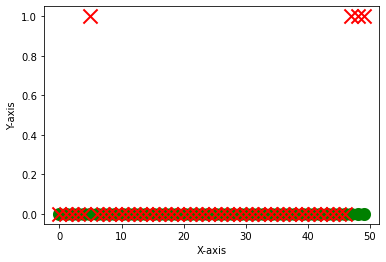

In [19]:
x1 = avp_df.index[:50]
y3 = avp_df['Prediction'][:50]
y4 = avp_df['Actual'][:50]

# When red(Actual winner) and green(predicted winner) are together in the below plot, that means prediction matches Actual results
plt.scatter(x1, y3, c ="green",
            linewidths = 6,
            marker ="o",
            s = 50)
 
plt.scatter(x1, y4, c ="red",
            linewidths = 2,
            marker ="x",
            s = 200)
 
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()